# Expedia Hotel Recommendation

Data Description

Expedia has provided you logs of customer behavior. These include what customers searched for, how they interacted with search results (click/book), whether or not the search result was a travel package. The data in this competition is a random selection from Expedia and is not representative of the overall statistics.

Expedia is interested in predicting which hotel group a user is going to book. Expedia has in-house algorithms to form hotel clusters, where similar hotels for a search (based on historical price, customer star ratings, geographical locations relative to city center, etc) are grouped together. These hotel clusters serve as good identifiers to which types of hotels people are going to book, while avoiding outliers such as new hotels that don't have historical data.

Your goal of this competition is to predict the booking outcome (hotel cluster) for a user event, based on their search and other attributes associated with that user event.

The train and test datasets are split based on time: training data from 2013 and 2014, while test data are from 2015. The public/private leaderboard data are split base on time as well. Training data includes all the users in the logs, including both click events and booking events. Test data only includes booking events. 

destinations.csv data consists of features extracted from hotel reviews text. 

Note that some srch_destination_id's in the train/test files don't exist in the destinations.csv file. This is because some hotels are new and don't have enough features in the latent space. Your algorithm should be able to handle this missing information.

In [1]:
# train/test.csv

# date_time(string) : Timestamp 
# site_name(int) : ID of the Expedia point of sale (i.e. Expedia.com, Expedia.co.uk, Expedia.co.jp, ...)
# posa_continent(int) : ID of continent associated with site_name
# user_location_country(int) : The ID of the country the customer is located
# user_location_region(int) : The ID of the region the customer is located
# user_location_city(int) : The ID of the city the customer is located
# orig_destination_distance(double) : Physical distance between a hotel and a customer at the time of search. A null means the distance could not be calculated	double
# user_id(int) : ID of user
# is_mobile(tinyint) : 1 when a user connected from a mobile device, 0 otherwise
# is_package(int) : 1 if the click/booking was generated as a part of a package (i.e. combined with a flight), 0 otherwise
# channel(int) : ID of a marketing channel
# srch_ci(string) : Checkin date
# srch_co(string) : Checkout date
# srch_adults_cnt(int) : The number of adults specified in the hotel room
# srch_children_cnt(int) : The number of (extra occupancy) children specified in the hotel room
# srch_rm_cnt(int) : The number of hotel rooms specified in the search
# srch_destination_id(int) : ID of the destination where the hotel search was performed
# srch_destination_type_id(int) : Type of destination
# hotel_continent(int) : Hotel continent
# hotel_country(int) : Hotel country
# hotel_market(int) : Hotel market
# is_booking(tinyint) : 1 if a booking, 0 if a click
# cnt(bigint) : Numer of similar events in the context of the same user session
# hotel_cluster(int) : ID of a hotel cluster

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import missingno as msno
import ml_metrics as metrics

In [3]:
destinations = pd.read_csv("destinations.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

### Check Dataset

In [4]:
print('destinations.shape', destinations.shape)

destinations.shape (62106, 150)


In [5]:
print('train.shape :', train.shape)
print('test.shape :', test.shape)

train.shape : (37670293, 24)
test.shape : (2528243, 22)


- train set 너무 많음 --> 이대로 계속 분석 가능한지?(메모리 이슈)

In [6]:
# check including missing values
# destinations.head()
destinations.tail() 

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
62101,64989,-2.145876,-2.158016,-2.216621,-2.158016,-2.006209,-2.102505,-2.216621,-2.157203,-2.216621,...,-2.216621,-2.158016,-2.158016,-2.216621,-2.216621,-2.216621,-2.216621,-2.216621,-2.216621,-2.152024
62102,64990,-2.203479,-2.203479,-2.203479,-2.203479,-2.203479,-2.176802,-2.203479,-2.203479,-2.203479,...,-2.203479,-2.203479,-2.203479,-2.203479,-2.203479,-2.203479,-2.203479,-2.203479,-2.203479,-2.008885
62103,64991,-2.190567,-2.208308,-2.208308,-2.208308,-2.208308,-2.135493,-2.208308,-2.208308,-1.909808,...,-2.188935,-2.208308,-2.175594,-2.208308,-2.208308,-2.199347,-2.208308,-2.208308,-2.208308,-2.208308
62104,64992,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,...,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686
62105,64993,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,...,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457


- row index와 srch_destination_id가 차이나는 것으로 보아, missing된 id가 많이 존재하는 것으로 판단 -> 어떻게 처리할지?

In [7]:
train.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


- 대부분 integer, float variable
- date time는 유용한 피처이므로, format 변경 필요
- user_loaction_country, user_location_city의 정확한 의미 알 수 없어 사용이 어려워 보임
- orig_destination_distance Nan 어떻게 처리할지?

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37670293 entries, 0 to 37670292
Data columns (total 24 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   date_time                  object 
 1   site_name                  int64  
 2   posa_continent             int64  
 3   user_location_country      int64  
 4   user_location_region       int64  
 5   user_location_city         int64  
 6   orig_destination_distance  float64
 7   user_id                    int64  
 8   is_mobile                  int64  
 9   is_package                 int64  
 10  channel                    int64  
 11  srch_ci                    object 
 12  srch_co                    object 
 13  srch_adults_cnt            int64  
 14  srch_children_cnt          int64  
 15  srch_rm_cnt                int64  
 16  srch_destination_id        int64  
 17  srch_destination_type_id   int64  
 18  is_booking                 int64  
 19  cnt                        int64  
 20  

In [9]:
test.head()

,id,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,...,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,hotel_continent,hotel_country,hotel_market
0,0,2015-09-03 17:09:54,2,3,66,174,37449,5539.0567,1,1,...,2016-05-19,2016-05-23,2,0,1,12243,6,6,204,27
1,1,2015-09-24 17:38:35,2,3,66,174,37449,5873.2923,1,1,...,2016-05-12,2016-05-15,2,0,1,14474,7,6,204,1540
2,2,2015-06-07 15:53:02,2,3,66,142,17440,3975.9776,20,0,...,2015-07-26,2015-07-27,4,0,1,11353,1,2,50,699
3,3,2015-09-14 14:49:10,2,3,66,258,34156,1508.5975,28,0,...,2015-09-14,2015-09-16,2,0,1,8250,1,2,50,628
4,4,2015-07-17 09:32:04,2,3,66,467,36345,66.7913,50,0,...,2015-07-22,2015-07-23,2,0,1,11812,1,2,50,538


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2528243 entries, 0 to 2528242
Data columns (total 22 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   id                         int64  
 1   date_time                  object 
 2   site_name                  int64  
 3   posa_continent             int64  
 4   user_location_country      int64  
 5   user_location_region       int64  
 6   user_location_city         int64  
 7   orig_destination_distance  float64
 8   user_id                    int64  
 9   is_mobile                  int64  
 10  is_package                 int64  
 11  channel                    int64  
 12  srch_ci                    object 
 13  srch_co                    object 
 14  srch_adults_cnt            int64  
 15  srch_children_cnt          int64  
 16  srch_rm_cnt                int64  
 17  srch_destination_id        int64  
 18  srch_destination_type_id   int64  
 19  hotel_continent            int64  
 20  ho

In [11]:
train.describe()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
count,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,2.414529e+07,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,...,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07
mean,9.795271e+00,2.680473e+00,8.610880e+01,3.084060e+02,2.775304e+04,1.970090e+03,6.044518e+05,1.349265e-01,2.489042e-01,5.870761e+00,...,3.321222e-01,1.112663e+00,1.444109e+04,2.582280e+00,7.965675e-02,1.483384e+00,3.156305e+00,8.129685e+01,6.004619e+02,4.980861e+01
std,1.196754e+01,7.480393e-01,5.924310e+01,2.084437e+02,1.678255e+04,2.232442e+03,3.506175e+05,3.416451e-01,4.323782e-01,3.717095e+00,...,7.314981e-01,4.591155e-01,1.106630e+04,2.153019e+00,2.707611e-01,1.219776e+00,1.623189e+00,5.617119e+01,5.117391e+02,2.891595e+01
min,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.600000e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,3.000000e+00,6.600000e+01,1.740000e+02,1.300900e+04,3.131670e+02,2.989100e+05,0.000000e+00,0.000000e+00,2.000000e+00,...,0.000000e+00,1.000000e+00,8.267000e+03,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,5.000000e+01,1.600000e+02,2.500000e+01
50%,2.000000e+00,3.000000e+00,6.600000e+01,3.140000e+02,2.765500e+04,1.140491e+03,6.039140e+05,0.000000e+00,0.000000e+00,9.000000e+00,...,0.000000e+00,1.000000e+00,9.147000e+03,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,5.000000e+01,5.930000e+02,4.900000e+01
75%,1.400000e+01,3.000000e+00,7.000000e+01,3.850000e+02,4.241300e+04,2.552599e+03,9.101680e+05,0.000000e+00,0.000000e+00,9.000000e+00,...,0.000000e+00,1.000000e+00,1.879000e+04,5.000000e+00,0.000000e+00,2.000000e+00,4.000000e+00,1.060000e+02,7.010000e+02,7.300000e+01
max,5.300000e+01,4.000000e+00,2.390000e+02,1.027000e+03,5.650800e+04,1.240790e+04,1.198785e+06,1.000000e+00,1.000000e+00,1.000000e+01,...,9.000000e+00,8.000000e+00,6.510700e+04,9.000000e+00,1.000000e+00,2.690000e+02,6.000000e+00,2.120000e+02,2.117000e+03,9.900000e+01


In [12]:
test.describe()

,id,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,hotel_continent,hotel_country,hotel_market
count,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06,1.680782e+06,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06
mean,1.264121e+06,9.709666e+00,2.697413e+00,8.551612e+01,3.170341e+02,2.786218e+04,1.686398e+03,6.026459e+05,1.425978e-01,1.093253e-01,6.493726e+00,1.958127e+00,2.507413e-01,1.117410e+00,1.656862e+04,2.941702e+00,3.022615e+00,8.125454e+01,6.464926e+02
std,7.298410e+05,1.227183e+01,7.651288e-01,5.673880e+01,2.082834e+02,1.668788e+04,2.197361e+03,3.469651e+05,3.496623e-01,3.120470e-01,3.931422e+00,8.980415e-01,6.754566e-01,4.615010e-01,1.280502e+04,2.282006e+00,1.674879e+00,5.507528e+01,5.046530e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.600000e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.320605e+05,2.000000e+00,3.000000e+00,6.600000e+01,1.740000e+02,1.354200e+04,2.080691e+02,3.020785e+05,0.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,8.267000e+03,1.000000e+00,2.000000e+00,5.000000e+01,2.750000e+02
50%,1.264121e+06,2.000000e+00,3.000000e+00,6.600000e+01,3.180000e+02,2.765500e+04,7.278764e+02,6.041940e+05,0.000000e+00,0.000000e+00,9.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,1.201200e+04,1.000000e+00,2.000000e+00,5.000000e+01,6.280000e+02
75%,1.896182e+06,1.300000e+01,3.000000e+00,6.900000e+01,3.980000e+02,4.232800e+04,2.222729e+03,9.038295e+05,0.000000e+00,0.000000e+00,1.000000e+01,2.000000e+00,0.000000e+00,1.000000e+00,2.354100e+04,6.000000e+00,4.000000e+00,1.050000e+02,7.830000e+02
max,2.528242e+06,5.300000e+01,4.000000e+00,2.390000e+02,1.027000e+03,5.650900e+04,1.220623e+04,1.198785e+06,1.000000e+00,1.000000e+00,1.000000e+01,9.000000e+00,9.000000e+00,8.000000e+00,6.578000e+04,9.000000e+00,6.000000e+00,2.120000e+02,2.117000e+03


In [13]:
print(len(train.columns), train.columns)
print(len(test.columns), test.columns)

24 Index(['date_time', 'site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market',
       'hotel_cluster'],
      dtype='object')
22 Index(['id', 'date_time', 'site_name', 'posa_continent',
       'user_location_country', 'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'hotel_continent', 'hotel_country', 'hotel_market'],
      dtype='object')


### Check null data 

In [14]:
for col in train.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (train[col].isnull().sum() / train[col].shape[0]))
    print(msg)

column:  date_time	 Percent of NaN value: 0.00%
column:  site_name	 Percent of NaN value: 0.00%
column: posa_continent	 Percent of NaN value: 0.00%
column: user_location_country	 Percent of NaN value: 0.00%
column: user_location_region	 Percent of NaN value: 0.00%
column: user_location_city	 Percent of NaN value: 0.00%
column: orig_destination_distance	 Percent of NaN value: 35.90%
column:    user_id	 Percent of NaN value: 0.00%
column:  is_mobile	 Percent of NaN value: 0.00%
column: is_package	 Percent of NaN value: 0.00%
column:    channel	 Percent of NaN value: 0.00%
column:    srch_ci	 Percent of NaN value: 0.12%
column:    srch_co	 Percent of NaN value: 0.12%
column: srch_adults_cnt	 Percent of NaN value: 0.00%
column: srch_children_cnt	 Percent of NaN value: 0.00%
column: srch_rm_cnt	 Percent of NaN value: 0.00%
column: srch_destination_id	 Percent of NaN value: 0.00%
column: srch_destination_type_id	 Percent of NaN value: 0.00%
column: is_booking	 Percent of NaN value: 0.00%
col

- ID 없음
- orig_destination_distance 없는 것이 존재 (by data description)
- checkin/checkout missing value 존재

In [15]:
Nan_ci_idx = list(train.loc[train['srch_ci'].isnull()]['srch_ci'].index)
Nan_co_idx = list(train.loc[train['srch_co'].isnull()]['srch_co'].index)
print(len(Nan_ci_idx))
print(len(Nan_co_idx))

equal_idx = 0
for i in range(len(Nan_ci_idx)):
    if Nan_ci_idx[i] in Nan_co_idx:
        equal_idx += 1

print(equal_idx)

47083
47084
47079


- Checkin data와 Checkout data의 누락이 대부분 겹치치만, 각각 누락된 것도 있음

In [16]:
for col in test.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (test[col].isnull().sum() / test[col].shape[0]))
    print(msg)

column:         id	 Percent of NaN value: 0.00%
column:  date_time	 Percent of NaN value: 0.00%
column:  site_name	 Percent of NaN value: 0.00%
column: posa_continent	 Percent of NaN value: 0.00%
column: user_location_country	 Percent of NaN value: 0.00%
column: user_location_region	 Percent of NaN value: 0.00%
column: user_location_city	 Percent of NaN value: 0.00%
column: orig_destination_distance	 Percent of NaN value: 33.52%
column:    user_id	 Percent of NaN value: 0.00%
column:  is_mobile	 Percent of NaN value: 0.00%
column: is_package	 Percent of NaN value: 0.00%
column:    channel	 Percent of NaN value: 0.00%
column:    srch_ci	 Percent of NaN value: 0.00%
column:    srch_co	 Percent of NaN value: 0.00%
column: srch_adults_cnt	 Percent of NaN value: 0.00%
column: srch_children_cnt	 Percent of NaN value: 0.00%
column: srch_rm_cnt	 Percent of NaN value: 0.00%
column: srch_destination_id	 Percent of NaN value: 0.00%
column: srch_destination_type_id	 Percent of NaN value: 0.00%
col

- test set은 missing value 없음
- is_booking, cnt, hotel_cluster(label) column 없음

In [17]:
# msno.bar(df=train.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))
# msno.matrix(df=train.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))

In [18]:
# msno.bar(df=test.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))
# msno.matrix(df=test.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))

### Check target label

In [19]:
train['hotel_cluster'].value_counts()

91    1043720
41     772743
48     754033
64     704734
65     670960
       ...   
35     139122
53     134812
88     107784
27     105040
74      48355
Name: hotel_cluster, Length: 100, dtype: int64

48355 1043720


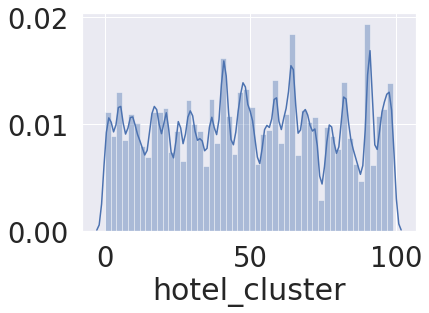

In [20]:
sns.distplot(train['hotel_cluster'])
print(min(train['hotel_cluster'].value_counts()), max(train['hotel_cluster'].value_counts()))

### Convert Dates to Year & Month

In [48]:
train['date_time'] = pd.to_datetime(train['date_time'])
train['year'] = train['date_time'].dt.year
train['month'] = train['date_time'].dt.month
train['day'] = train['date_time'].dt.day
train.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,year,month,day
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,1,0,3,2,50,628,1,2014,8,11
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,1,1,1,2,50,628,1,2014,8,11
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,1,0,1,2,50,628,1,2014,8,11
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,1,0,1,2,50,1457,80,2014,8,9
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,1,0,1,2,50,1457,21,2014,8,9


### Downsizing dataset (by Random sampling)

In [49]:
userid_group = train.groupby(['user_id'])['hotel_cluster'].value_counts()
print(userid_group)
print('unique user count :',train['user_id'].nunique())

user_id  hotel_cluster
0        19               1
         28               1
         40               1
         56               1
         72               1
                         ..
1198784  79               2
         26               1
         68               1
         95               1
1198785  76               2
Name: hotel_cluster, Length: 14865110, dtype: int64
unique user count : 1198786


- 1,198,786개 -> 20,000개 random sampling

In [50]:
unique_user_set = set(train['user_id'].unique())
sampling_user_set = random.sample(unique_user_set, 20000)

train_sampling = pd.DataFrame()
train_chunking = pd.read_csv('train.csv', chunksize = 100000)

for c in train_chunking:
    train_sampling = train_sampling.append(c.loc[c['user_id'].isin(sampling_user_set)])

print('sampling unique user count :',train_sampling['user_id'].nunique())    

sampling unique user count : 20000


In [ ]:
train_sampling['date_time'] = pd.to_datetime(train_sampling['date_time'])
train_sampling['year'] = train_sampling['date_time'].dt.year
train_sampling['month'] = train_sampling['date_time'].dt.month
train_sampling['day'] = train_sampling['date_time'].dt.day
train.head()

In [53]:
train_sampling.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
1090,2014-02-14 04:07:51,2,3,66,311,33705,2035.1640,6929,1,1,...,0,1,11334,1,0,1,4,96,201,33
1091,2014-02-14 13:56:41,2,3,66,335,44390,2180.7283,6929,1,1,...,0,1,11334,1,0,1,4,96,201,33
1092,2014-02-14 17:25:35,2,3,66,335,44390,2180.7283,6929,1,1,...,0,1,11334,1,0,2,4,96,201,33
1093,2014-02-14 17:27:39,2,3,66,335,44390,2180.7283,6929,1,1,...,0,1,11334,1,0,1,4,96,201,33
1094,2014-02-15 03:59:55,2,3,66,335,44390,2180.7283,6929,1,1,...,0,1,11334,1,0,1,4,96,201,33


In [52]:
train_sampling.groupby(['year','month'])['day'].value_counts

KeyError: 'year'

### EDA